In [ ]:
# reference
# # https://blog.csdn.net/qq_43426908/article/details/137770041
# diffusion model其实是在做分布映射，对于本案例：即将二维正态随机分布空间 映射为 二维S型空间
# 训练过程的样本就是空间中的一个点，此例中为二维点，图像案例中为图像张开的多维空间点（或者图像embedding后的多维隐空间点）

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

shape of s:  (10000, 2)


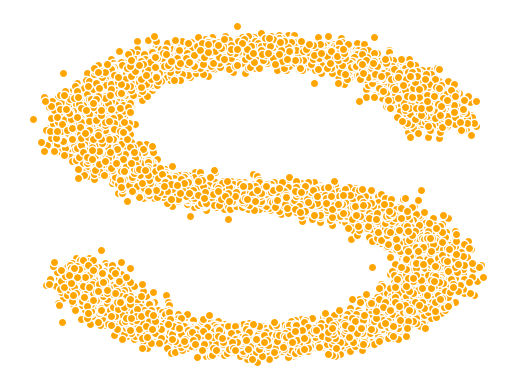

dataset size:  torch.Size([10000, 2])


In [45]:
# 准备数据集
s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0,2]]/10.0
print("shape of s: ", np.shape(s_curve))

data = s_curve.T
fig, ax = plt.subplots()
ax.scatter(*data, color='orange', edgecolors='white');
ax.axis('off')
plt.show()

dataset = torch.Tensor(s_curve).float()
dataset = dataset.to(device)
print('dataset size: ', dataset.size())
# print(torch.cuda.is_available())

In [46]:
# 准备alpha, beta等超参数
num_steps = 100
betas = torch.linspace(-6, 6, num_steps, device=device) # 递增
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5) + 1e-5 # beta_0, beta_1, ..., beta_t
# print(betas)

# 计算alpha, alpha_prod, alpha_prod_previous, alpha_bar_sqrt等变量的值
alphas = 1 - betas # alpha_t = 1 - beta_t
alphas_prod = torch.cumprod(alphas, 0) # alpha_t bar = alpha_t 累乘
# print(alphas_prod.size())
# print(alphas_prod)

# alpha_t^ 往右平移一位， 第0步补1
alphas_prod_p = torch.cat([torch.tensor([1], device=device).float(), alphas_prod[:-1]], 0)
# print(alphas_prod_p)

alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


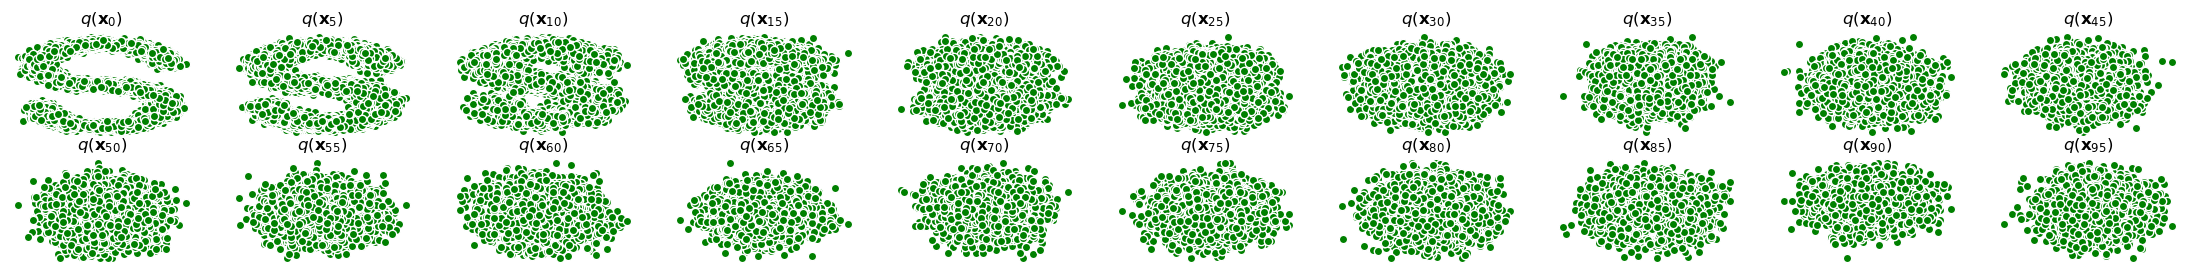

In [51]:
# 前向过程

# 计算任意时刻的x采样值，基于x_0和超参数
def q_x(x_0, t):
  """
    作用：前向过程, 可以基于x[0]得到任意时刻t的x[t]
    输入：x_0:初始干净图像；t：采样步
    输出：x_t:第t步时的x_0已成为的样子
  """
  noise = torch.randn_like(x_0, device=device) # noise为正态分布随机噪声

  alphas_t = alphas_bar_sqrt[t] # 根号下alpha_t_bar
  alphas_1_m_t = one_minus_alphas_bar_sqrt[t] # 根号下 (1 - alpha_t_bar)
  return (alphas_t * x_0 + alphas_1_m_t * noise)

num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='black')

# 共有10000个点，每个点包括两个坐标
# 生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
  row = i//10
  col = i%10
  q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows]))
  axs[row, col].scatter(q_i[:, 0].cpu().numpy(), q_i[:, 1].cpu().numpy(), color='green', edgecolor='white')
  axs[row, col].set_axis_off()
  axs[row, col].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

In [52]:
# 搭建模型

# 拟合逆向过程噪声的模型
class MLPDiffusion(nn.Module):
  def __init__(self, n_steps, hidden_size=128):
    super(MLPDiffusion, self).__init__()

    self.linears = nn.ModuleList(
      [
        nn.Linear(2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 2),
      ]
    )
    self.step_embeddings = nn.ModuleList(
      [
        nn.Embedding(n_steps, hidden_size), # [100, 128]
        nn.Embedding(n_steps, hidden_size),
        nn.Embedding(n_steps, hidden_size),
      ]
    )

  def forward(self, x, t):
    for idx, embedding_layer in enumerate(self.step_embeddings):
      t_embedding = embedding_layer(t) # 生成t的embedding
      x = self.linears[2 * idx](x) # 计算linear层
      x += t_embedding # 叠加 t embedding
      x = self.linears[2 * idx + 1](x) # 计算ReLU层

    x = self.linears[-1](x) # 最后一个linear层, 输出为[10000, 2]
    return x


In [54]:
# 定义损失函数

def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
  """
    作用：对任意时刻t进行采样计算loss
    参数：
        model: 模型
        x_0: 干净的图
        alphas_bar_sqrt: 根号下αt^
        one_minus_alphas_bar_sqrt: 根号下(1-αt^)
        n_steps: 采样步
  """
  batch_size = x_0.shape[0]

  # 对一个batchsize样本生成随机的时刻t，覆盖到更多不同的t
  t = torch.randint(0, n_steps, size=(batch_size//2,), device=device)
  t = torch.cat([t, n_steps - 1 - t], dim=0)
  t = t.unsqueeze(-1)

  # x0的系数
  a = alphas_bar_sqrt[t]

  # eps的系数
  aml = one_minus_alphas_bar_sqrt[t]

  # 生成随机噪声
  e = torch.randn_like(x_0, device=device)

  # 构造模型的输入
  x = x_0 * a + e * aml

  # 由模型计算t时刻的随机噪声预测值
  output = model(x, t.squeeze(-1))

  return (e - output).square().mean()

In [61]:
# 逆向过程

def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
  """
    作用：从x[T]恢复x[T-1]、x[T-2]、...x[0]
    输入：
        model:模型
        shape:数据大小,用于生成随机噪声
        n_steps:逆扩散总步长
        betas: βt
        one_minus_alphas_bar_sqrt: 根号下(1-αt^)
    输出：
        x_seq：一个序列的x, 即 x[T]、x[T-1]、x[T-2]、...x[0]
  """
  cur_x = torch.randn(shape, device=device) # 随机噪声, 对应xt
  x_seq = [cur_x]
  for i in reversed(range(n_steps)):
    cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
    x_seq.append(cur_x)
  return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
  """
    作用：从x[T]采样t时刻的重构值
    输入：
        model:模型
        x: 采样的随机噪声x[T]
        t: 采样步
        betas: βt
        one_minus_alphas_bar_sqrt: 根号下(1-αt^)
    输出：
        sample: 样本
  """
  t = torch.tensor([t], device=device)

  coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

  eps_theta = model(x, t) # 模型预测噪声

  mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

  z = torch.randn_like(x)
  sigma_t = betas[t].sqrt()

  sample = mean + sigma_t * z

  return (sample)

Training model...
tensor(0.5672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2058, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2674, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3574, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2978, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1929, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2824, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3354, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2990, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1762, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5011, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1435

/tmp/ipykernel_12105/1385607819.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 10, figsize=(28,3))


tensor(0.3508, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3814, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2508, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2935, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2784, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3185, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7182, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3713, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5640, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2832, device='cuda:0',

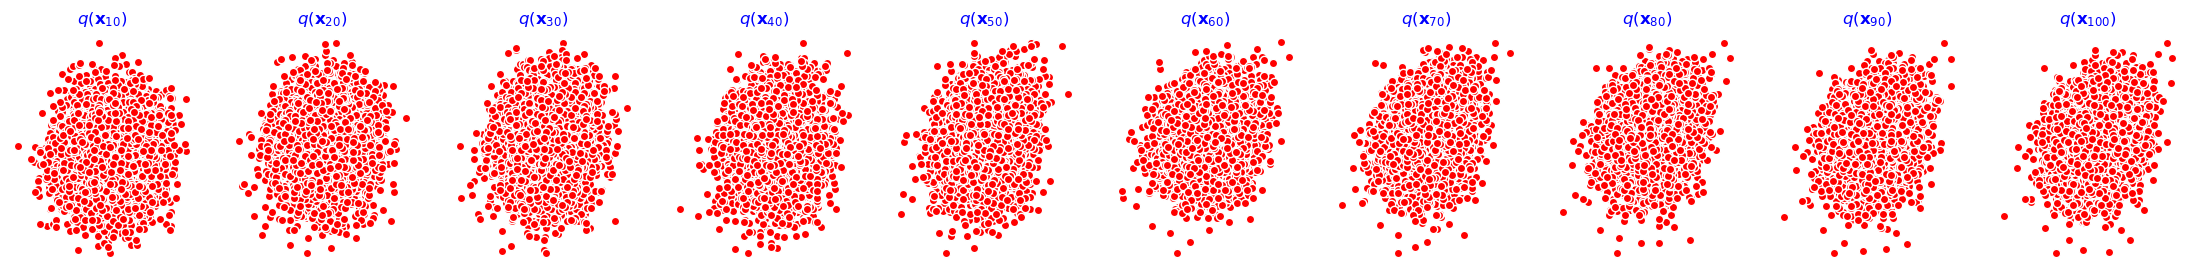

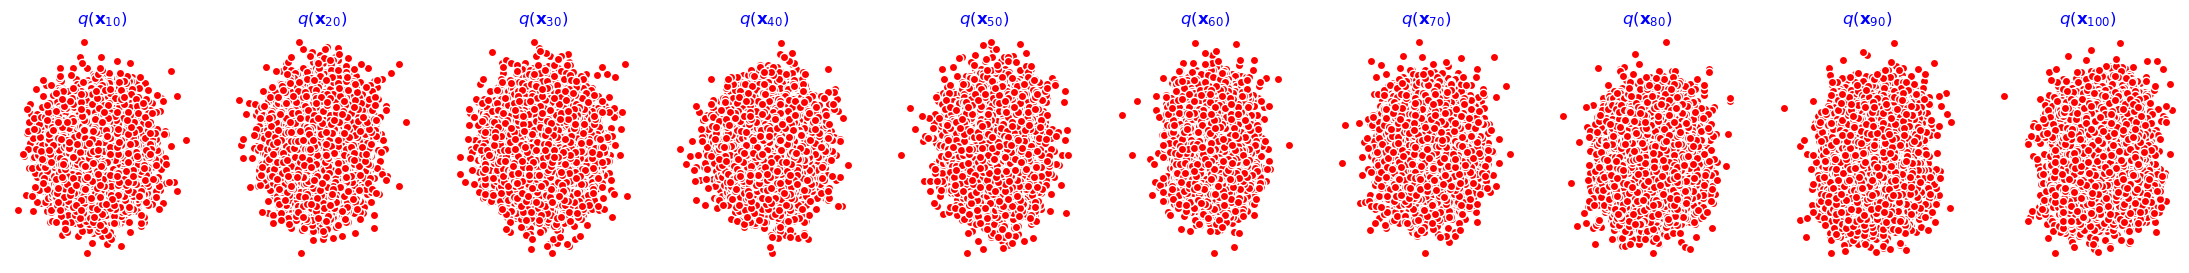

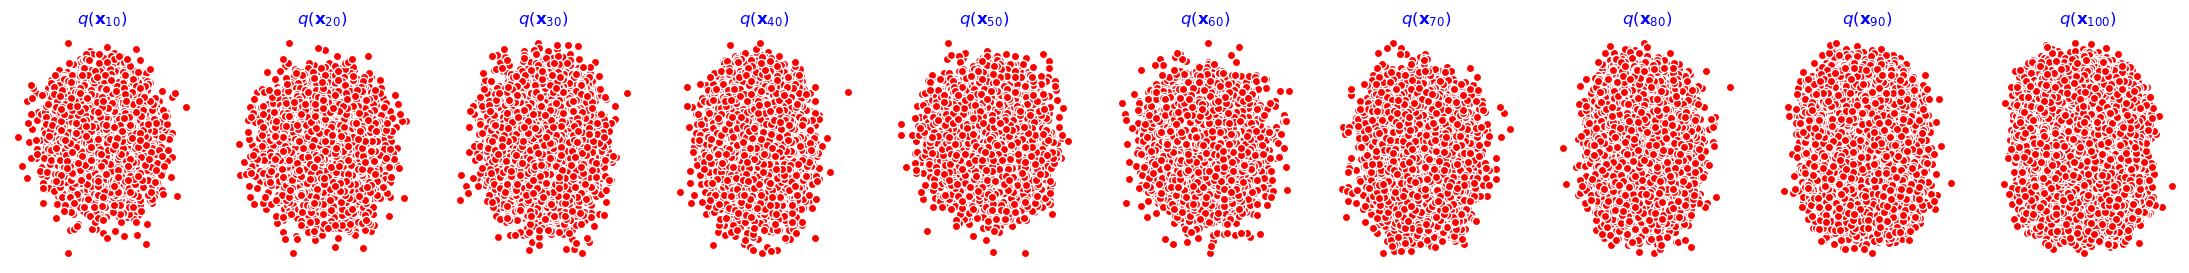

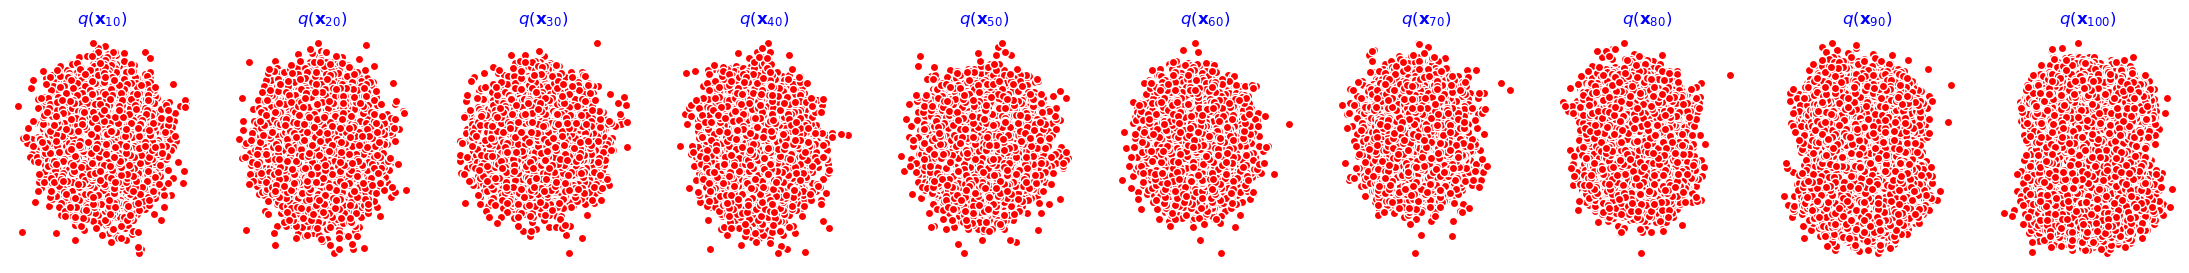

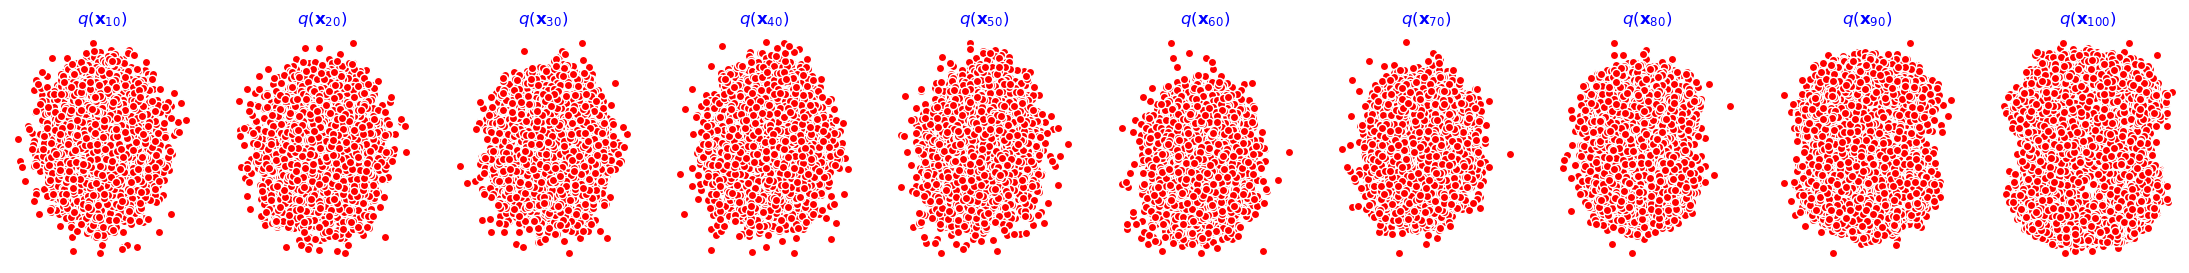

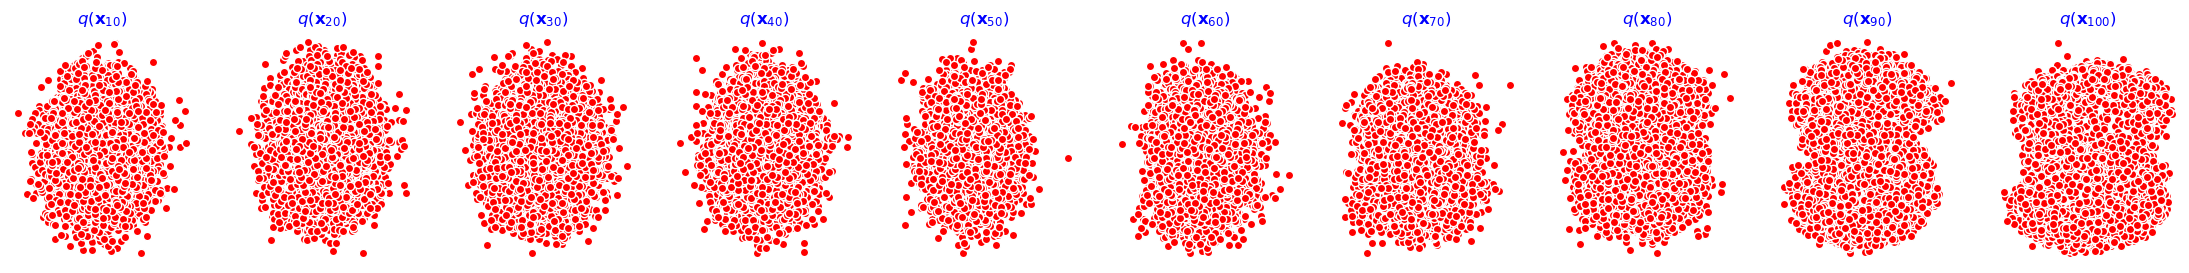

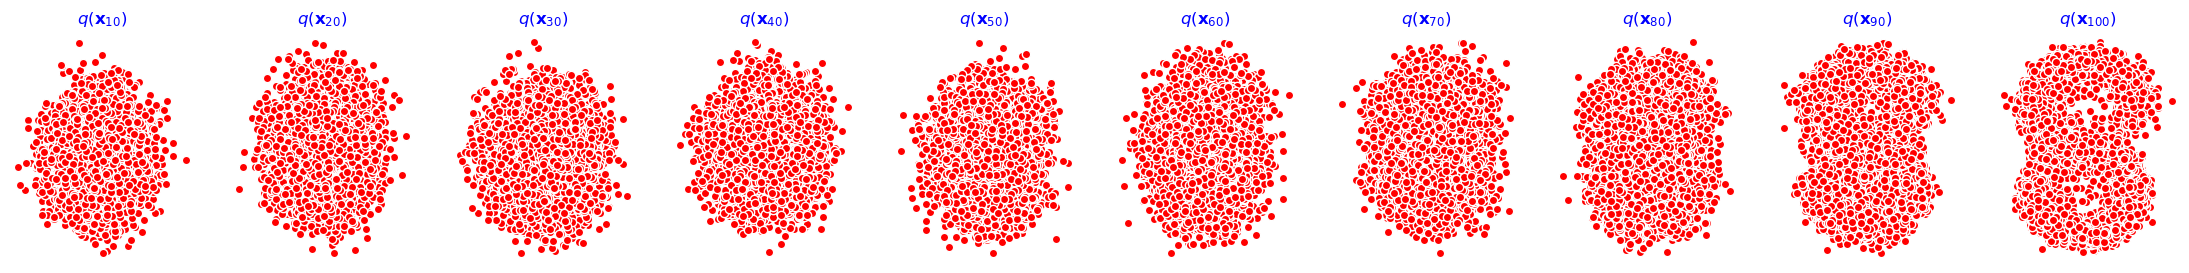

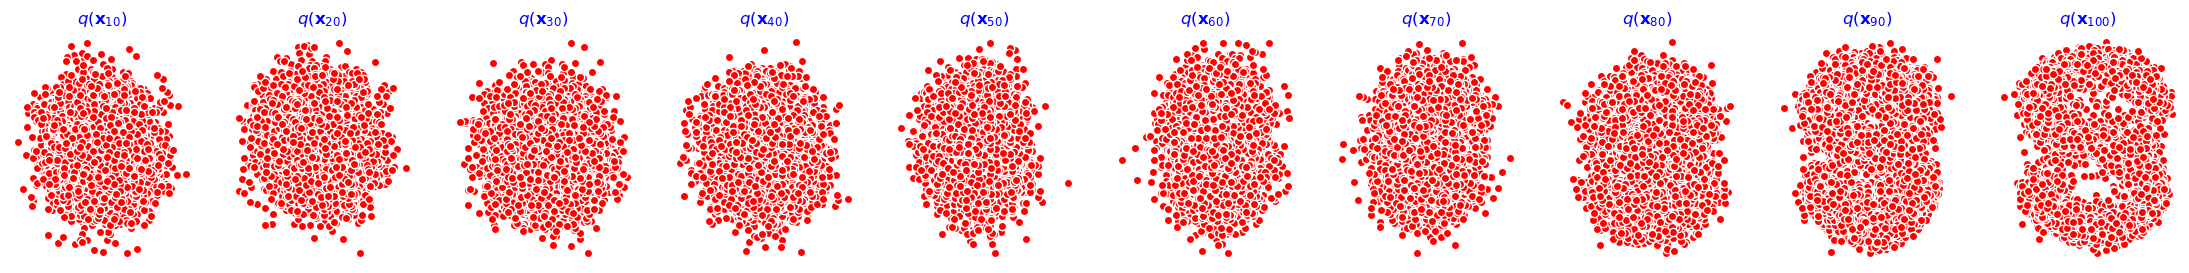

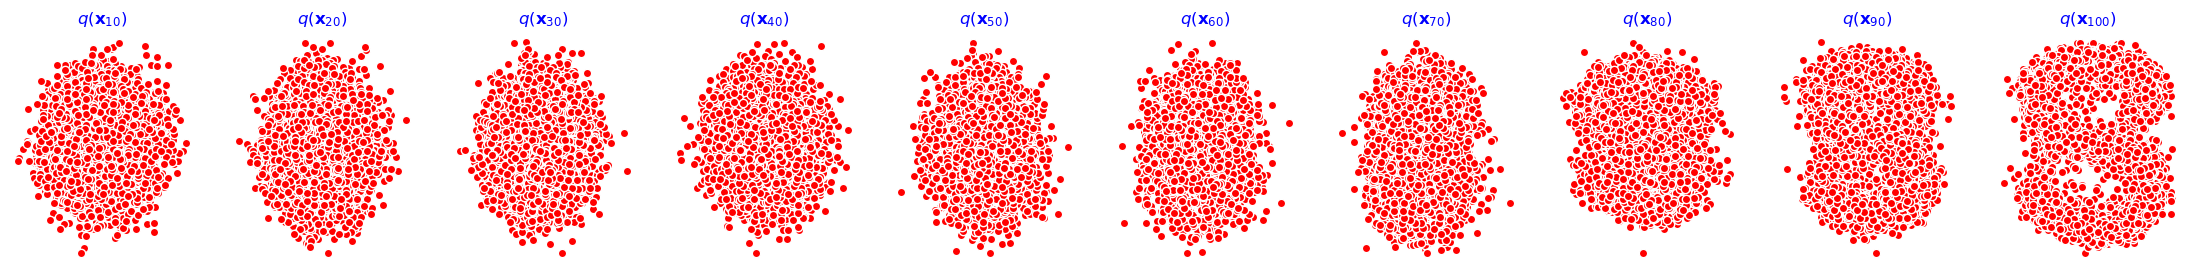

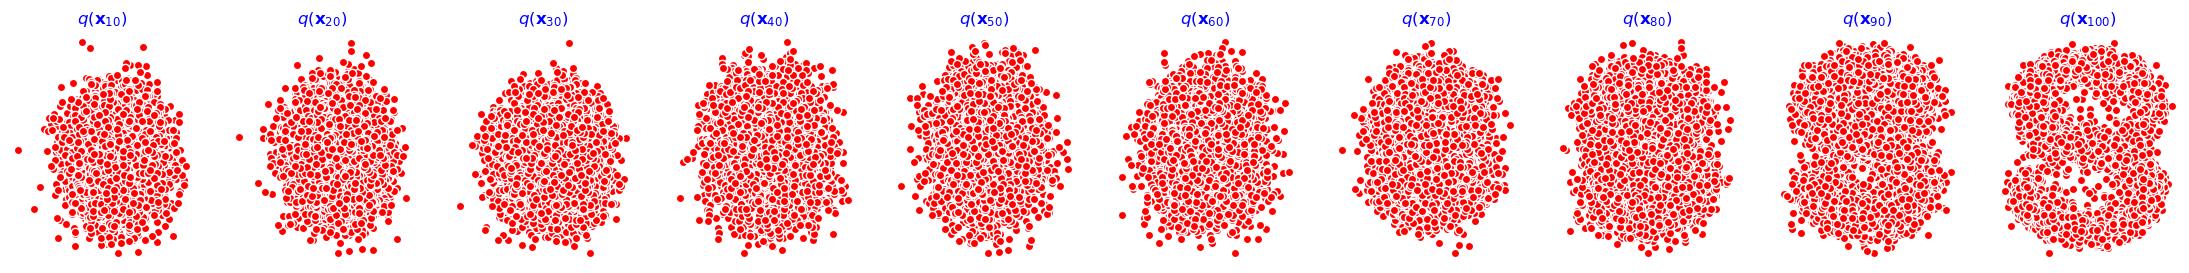

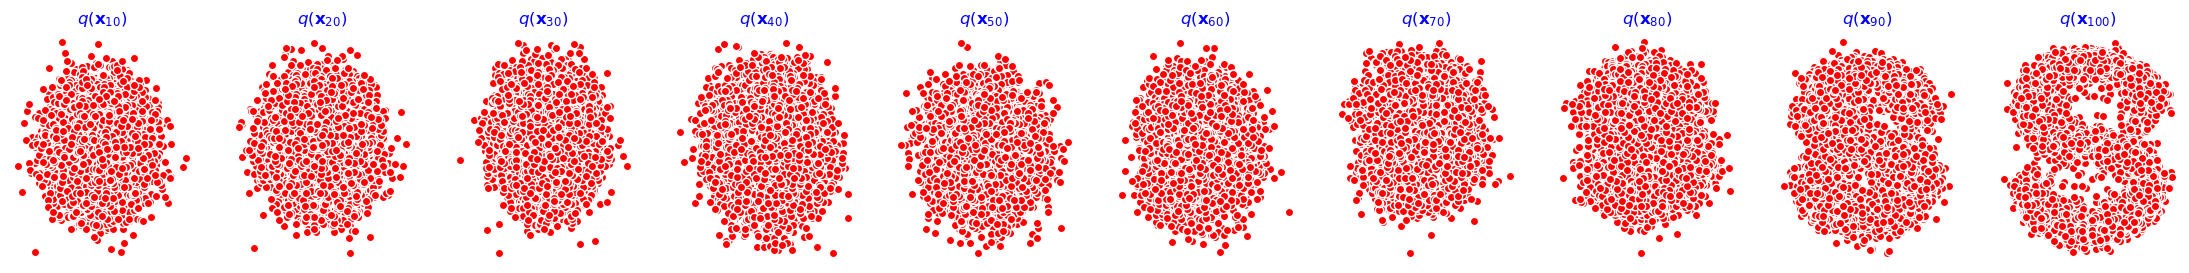

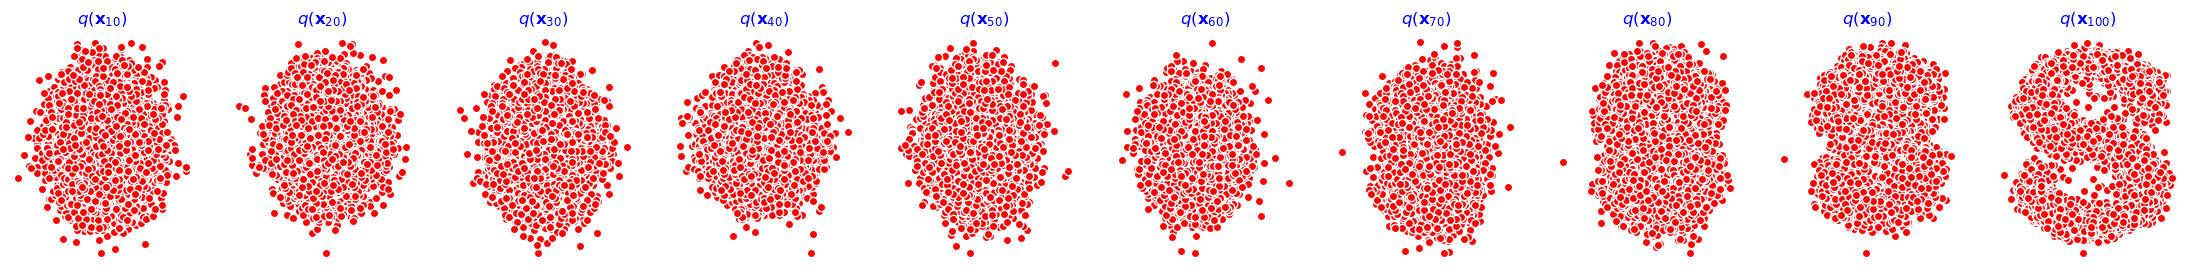

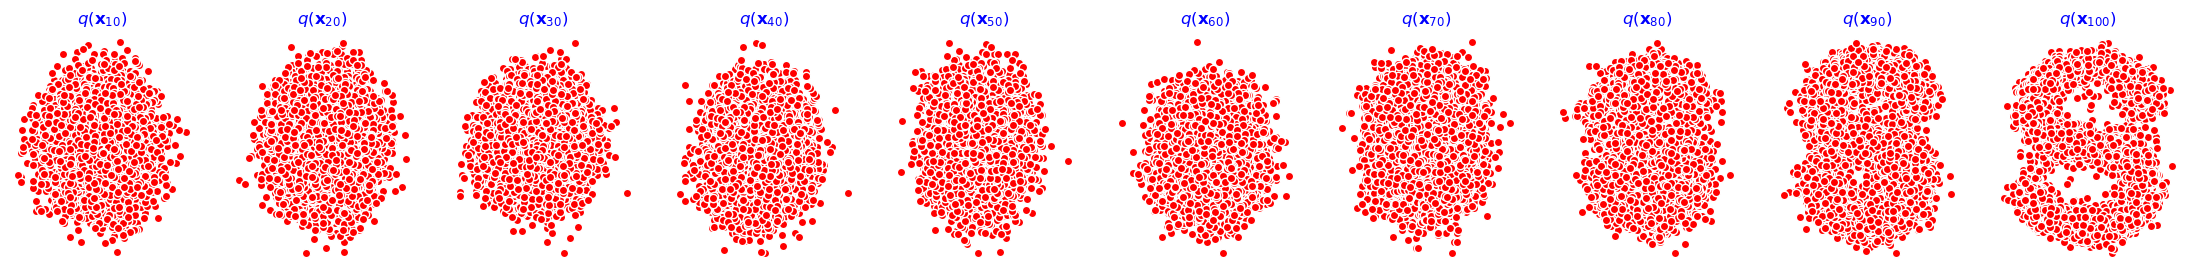

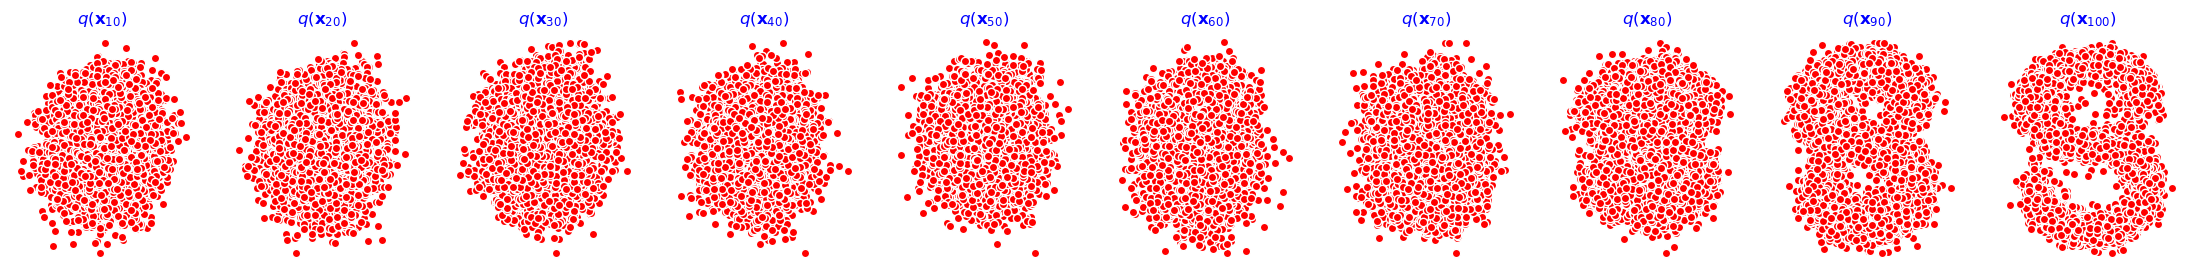

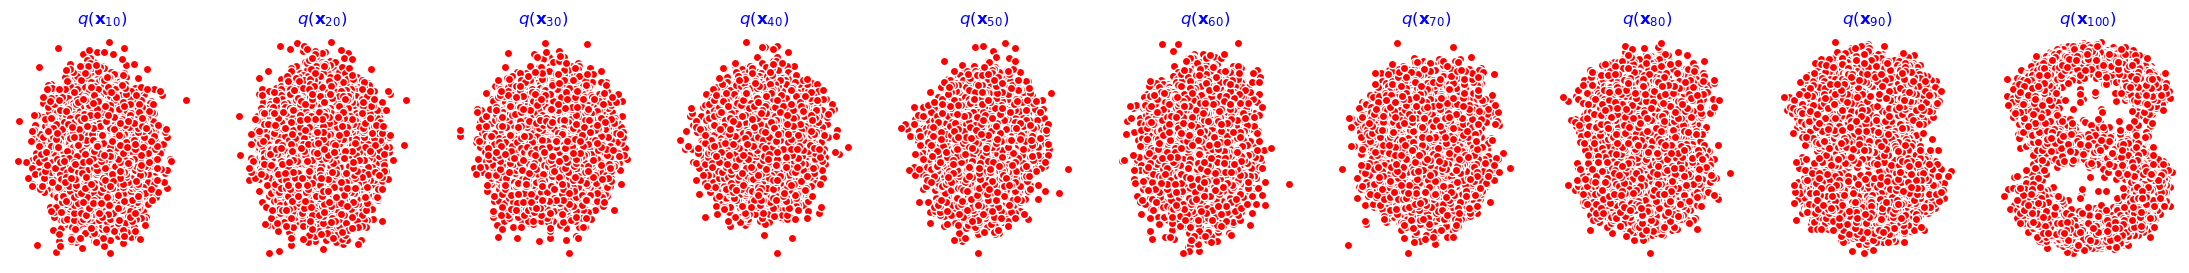

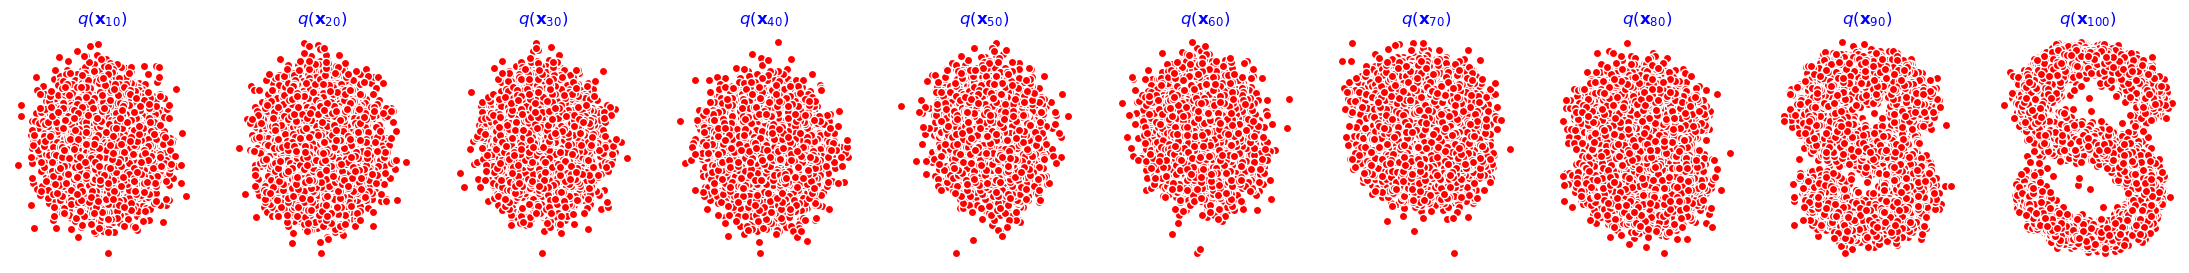

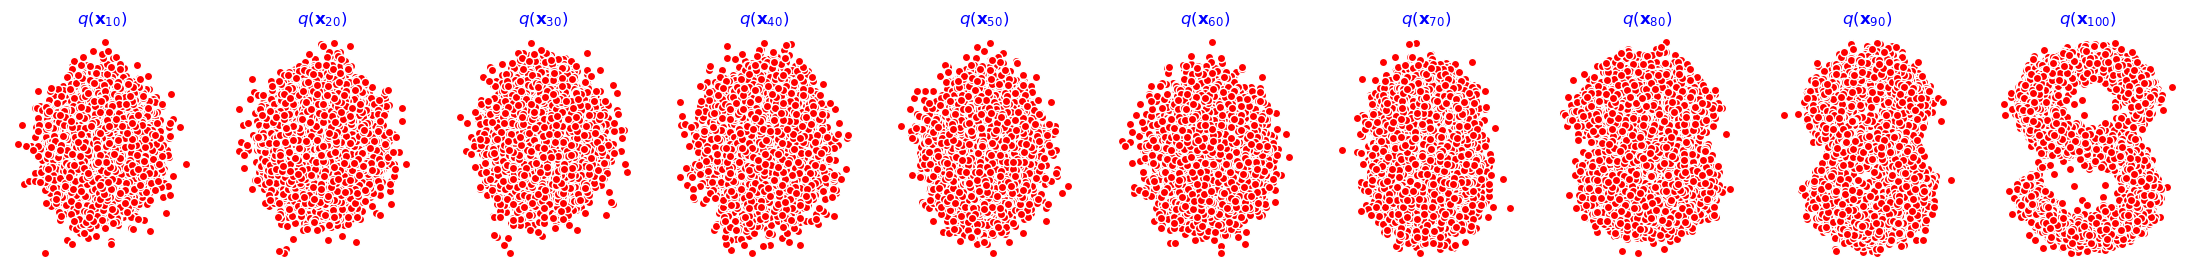

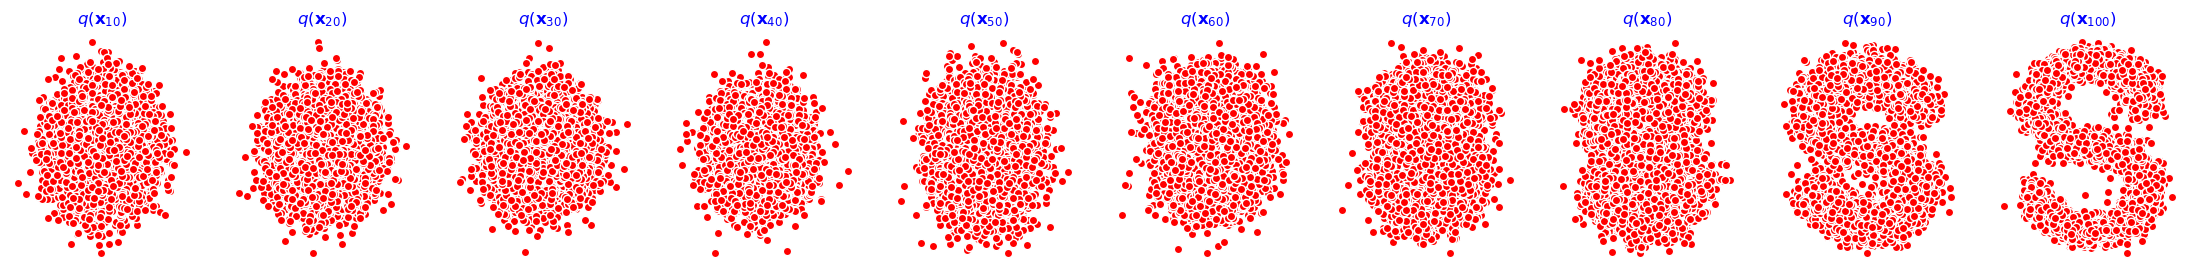

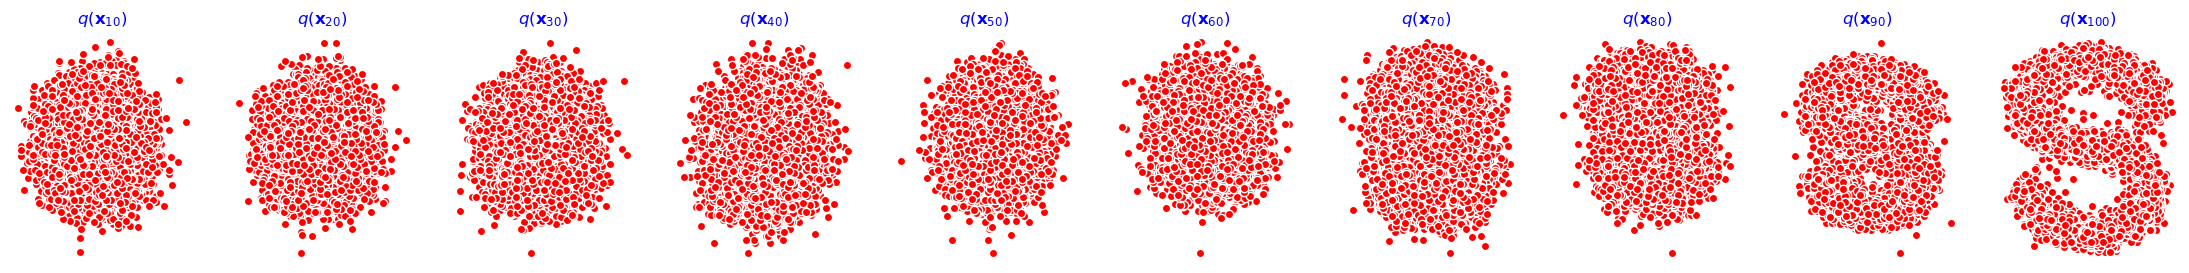

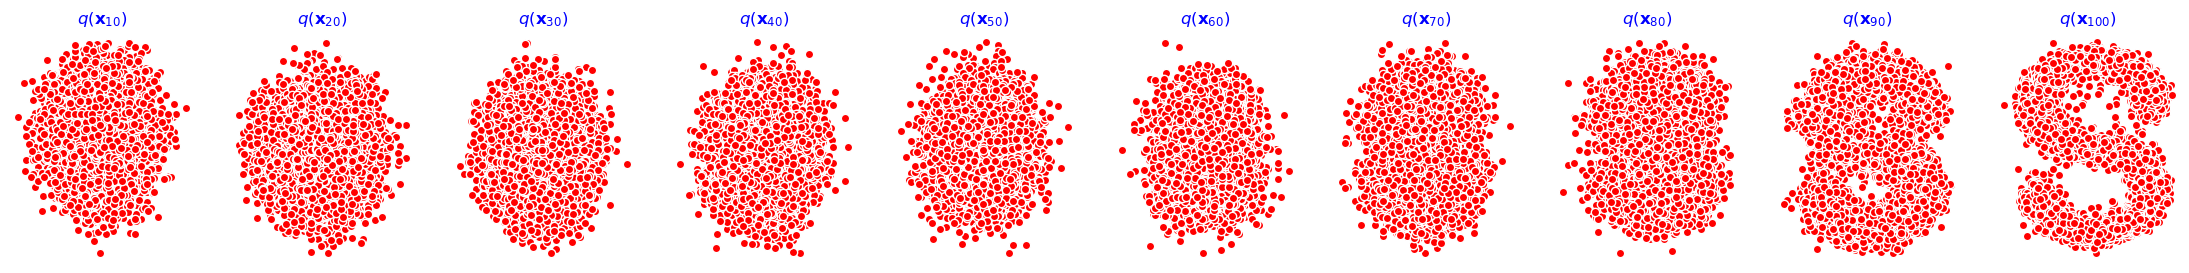

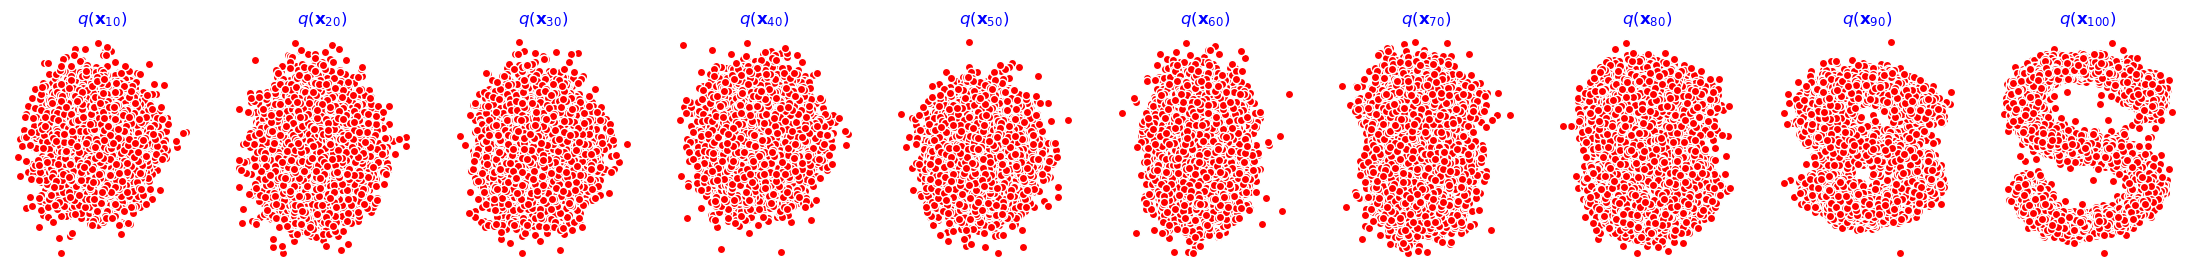

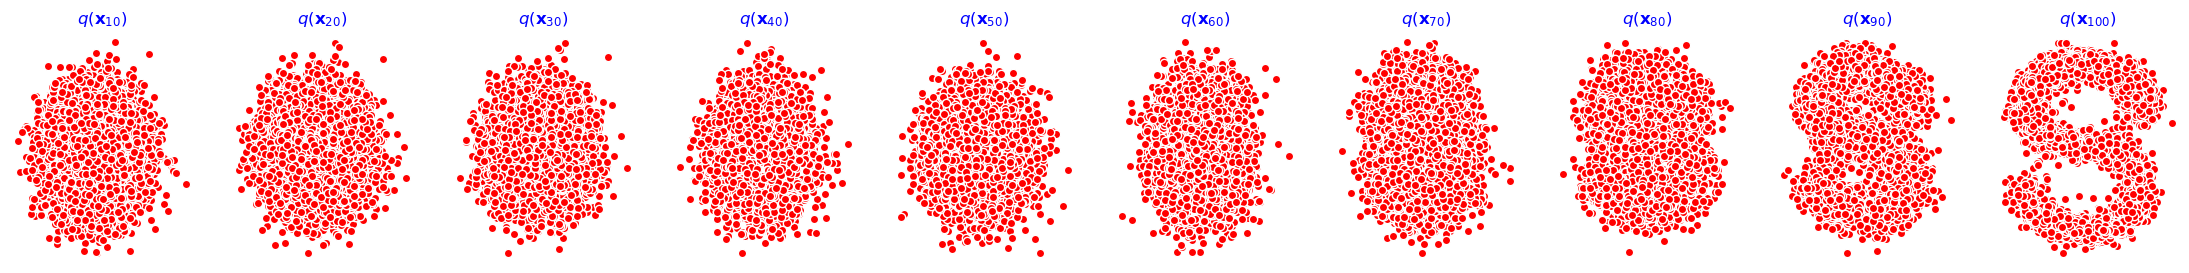

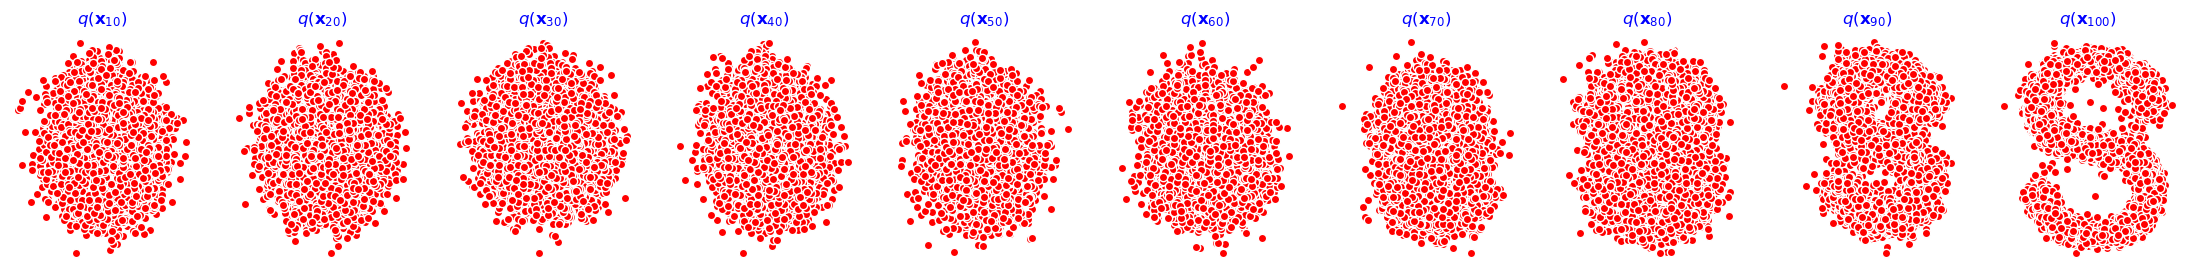

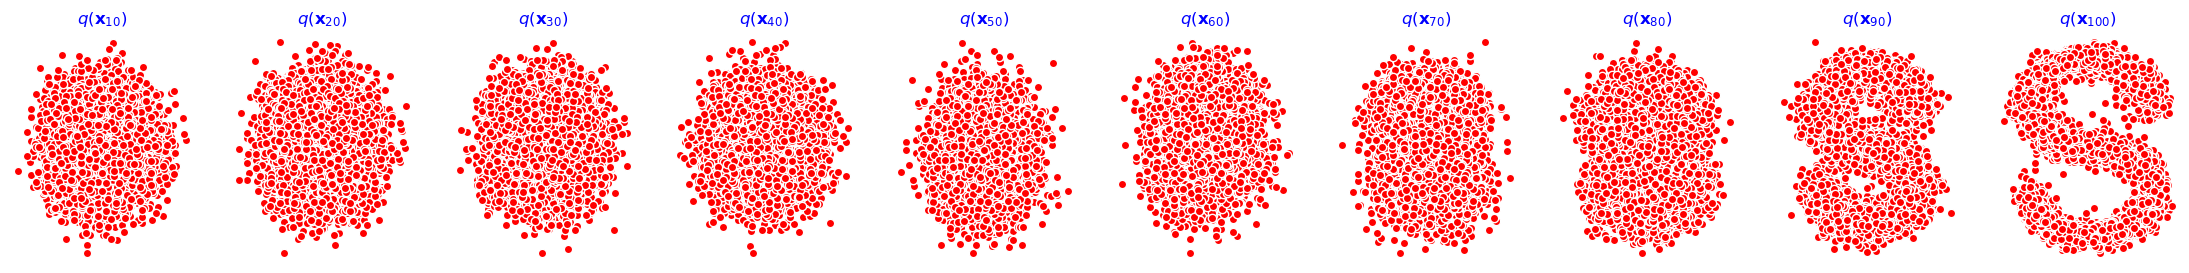

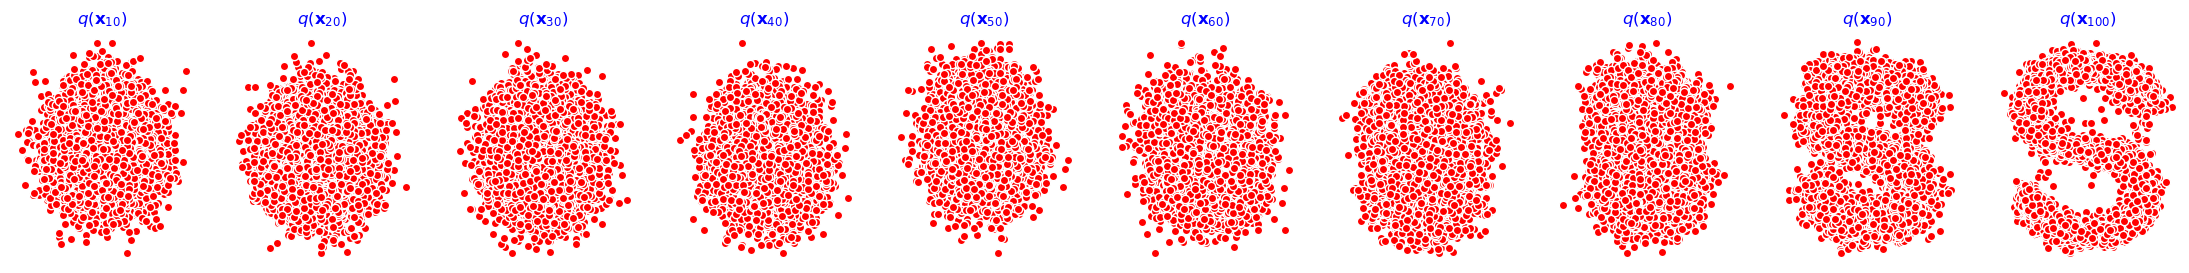

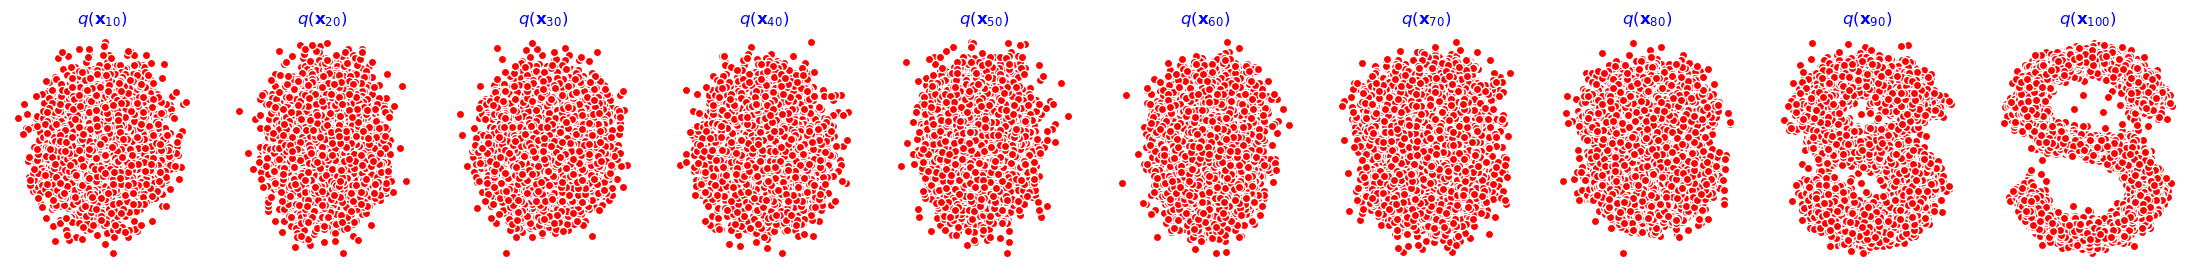

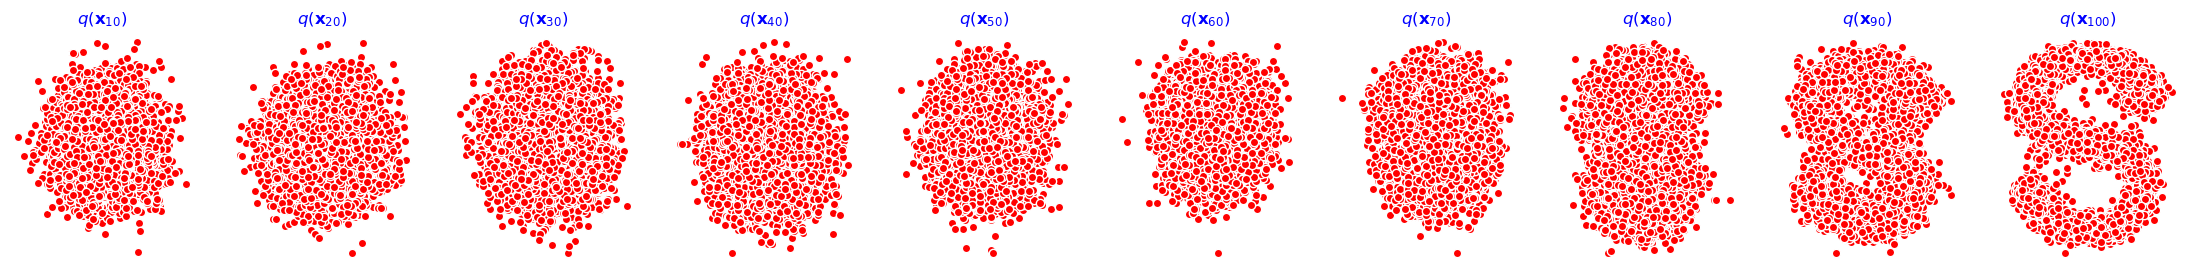

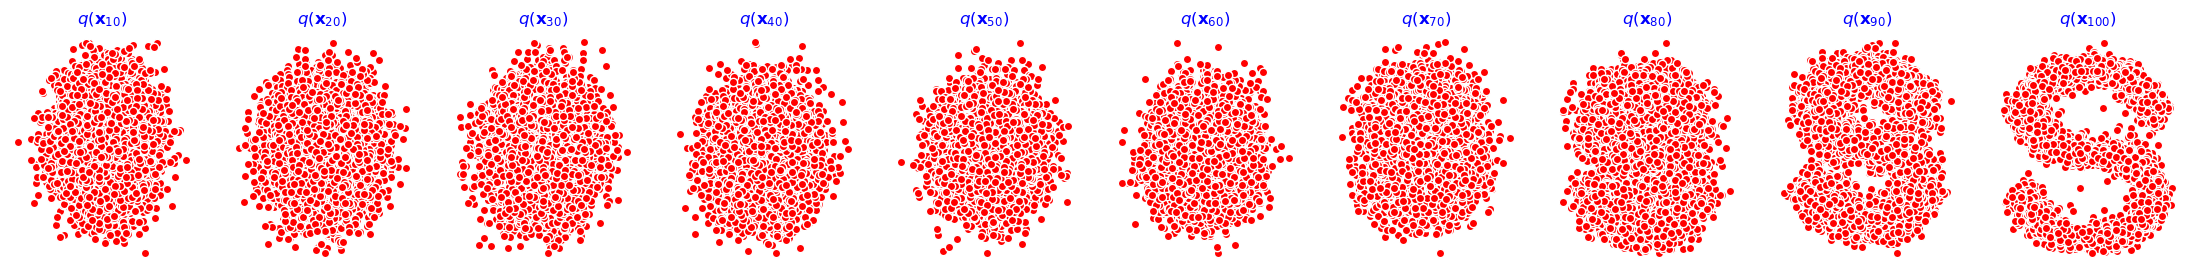

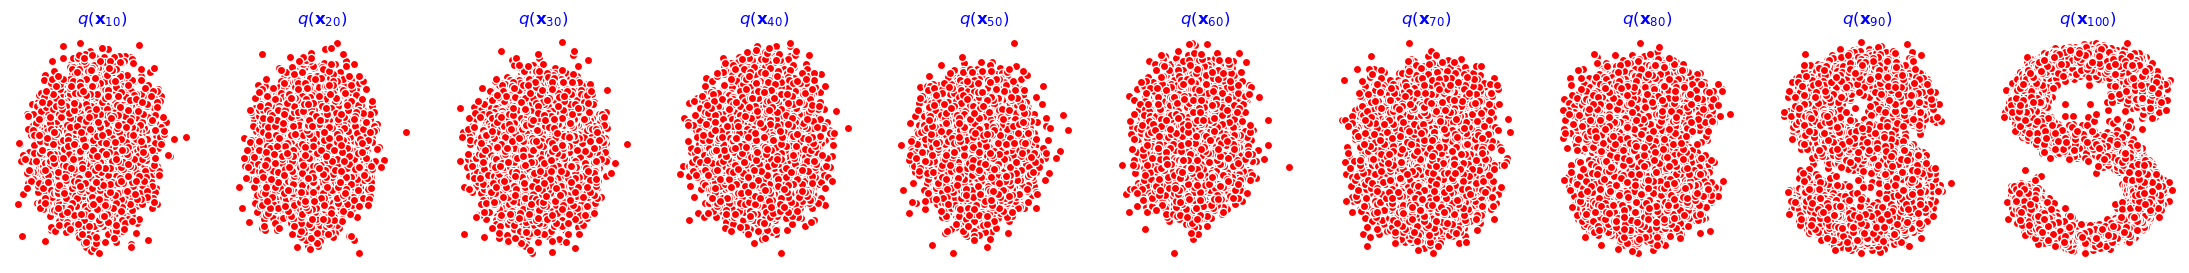

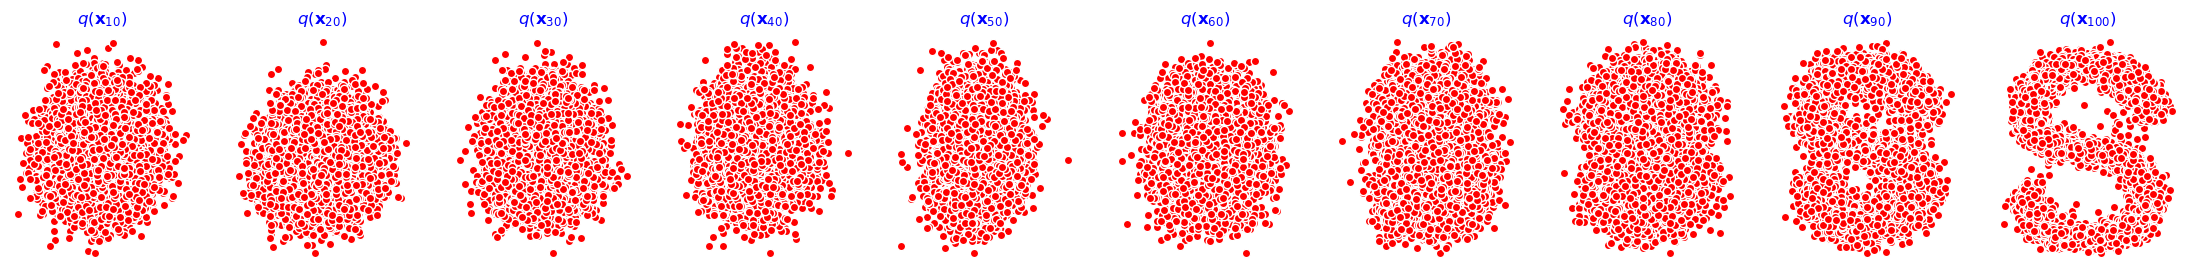

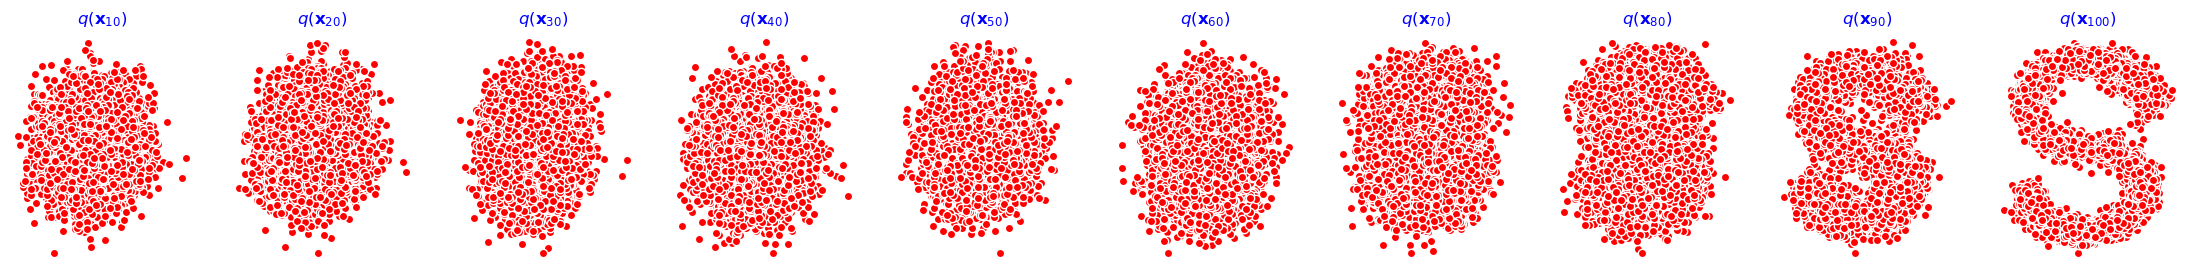

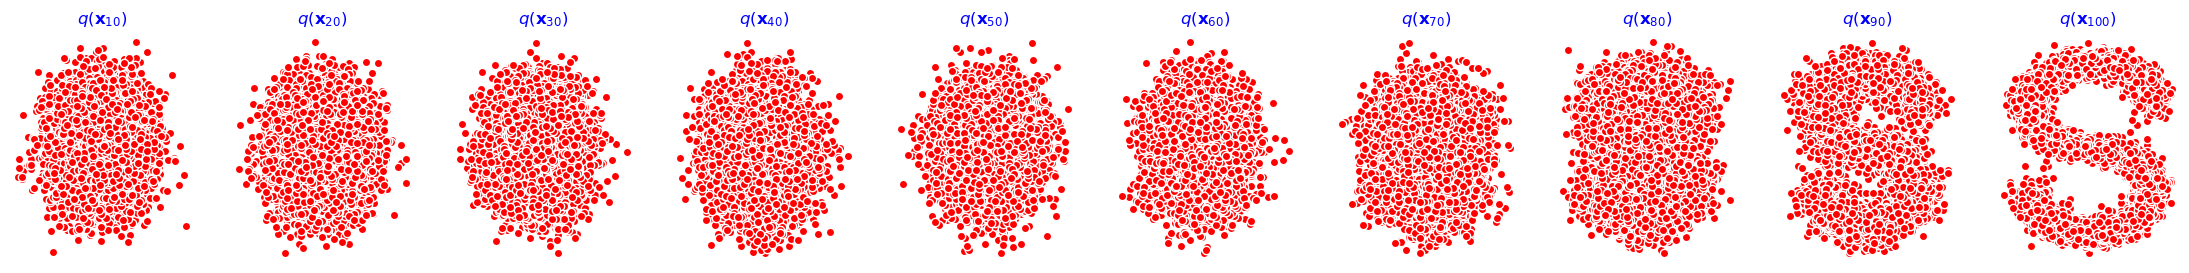

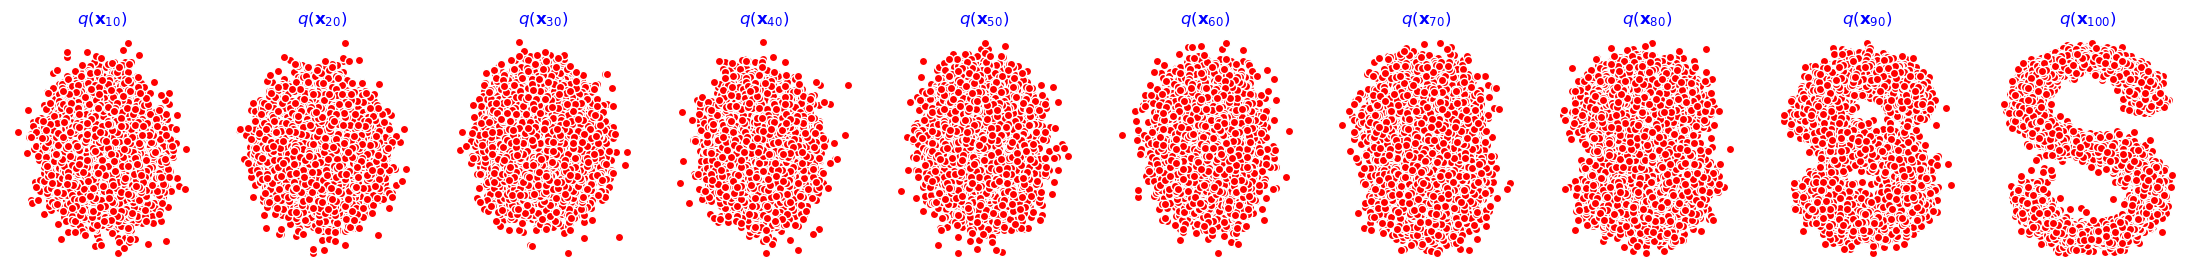

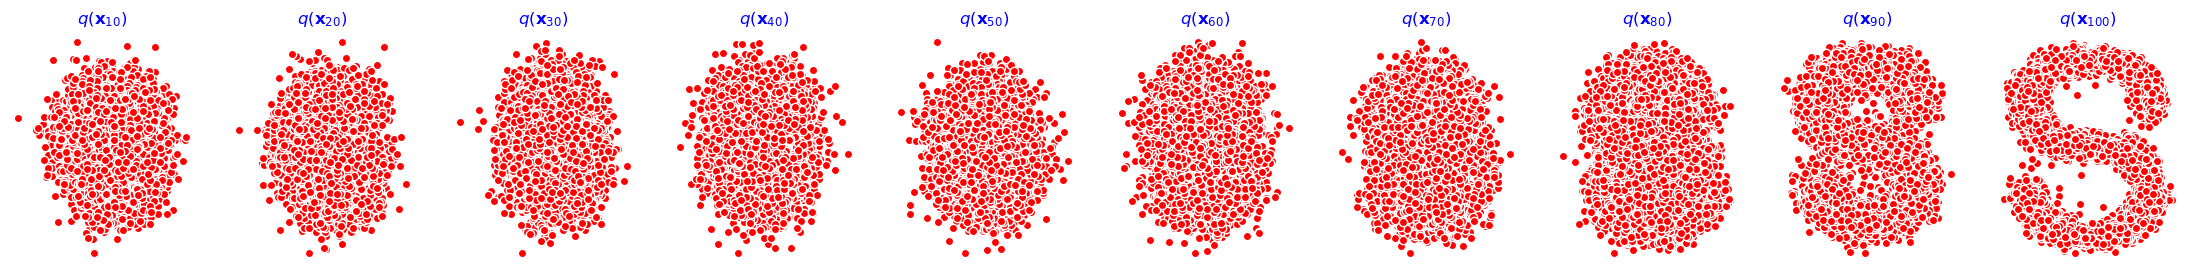

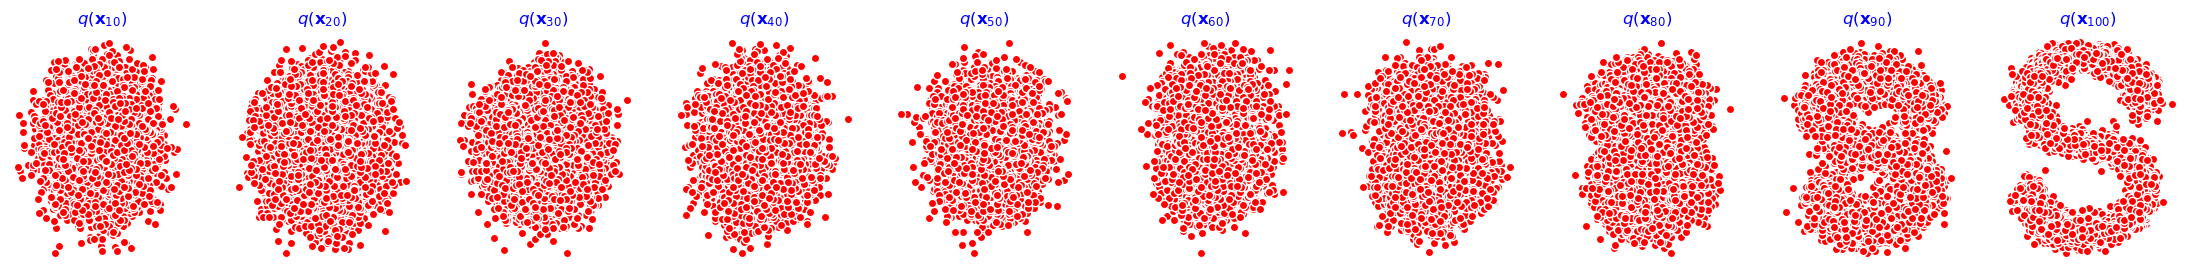

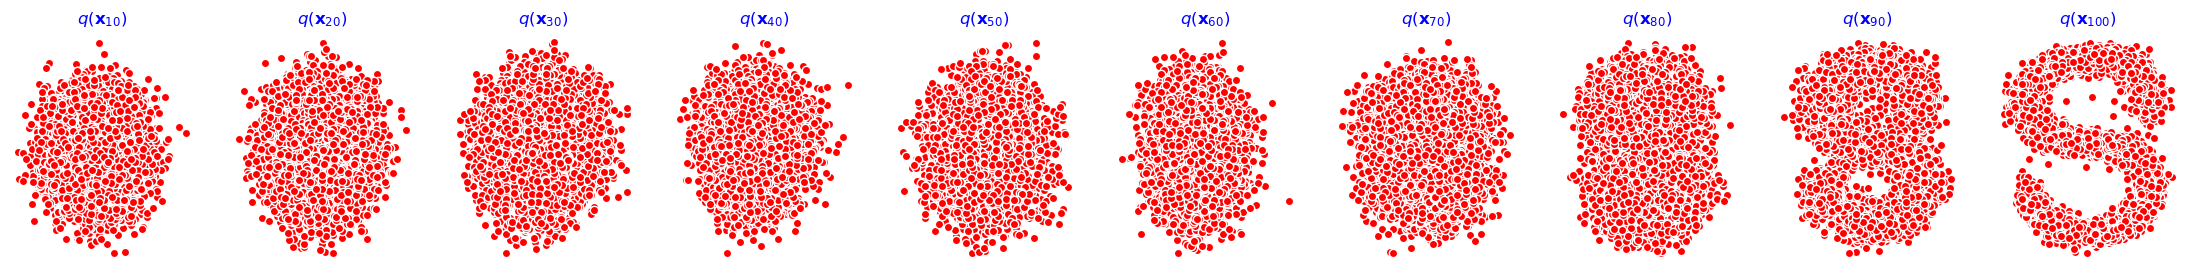

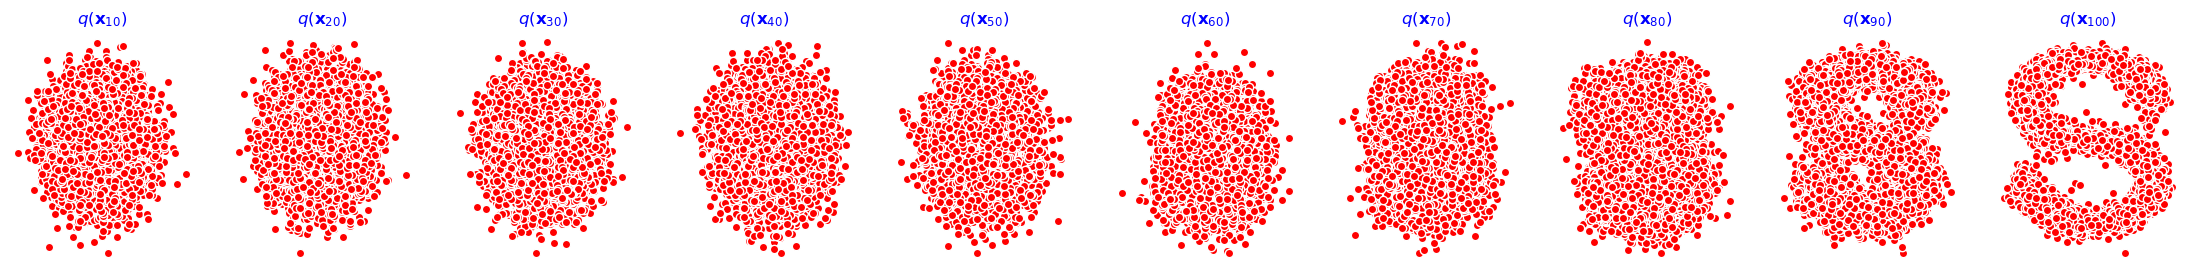

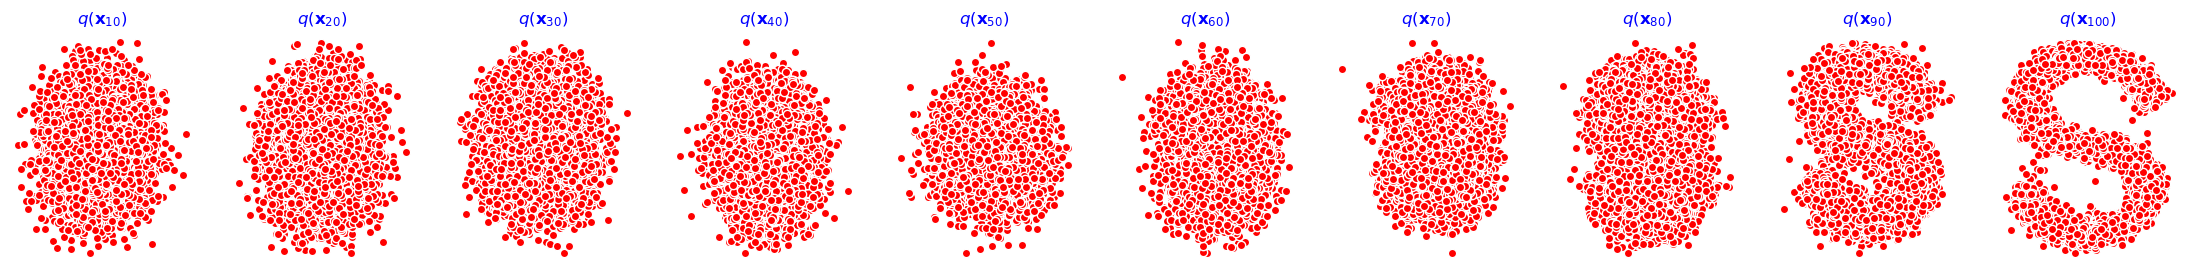

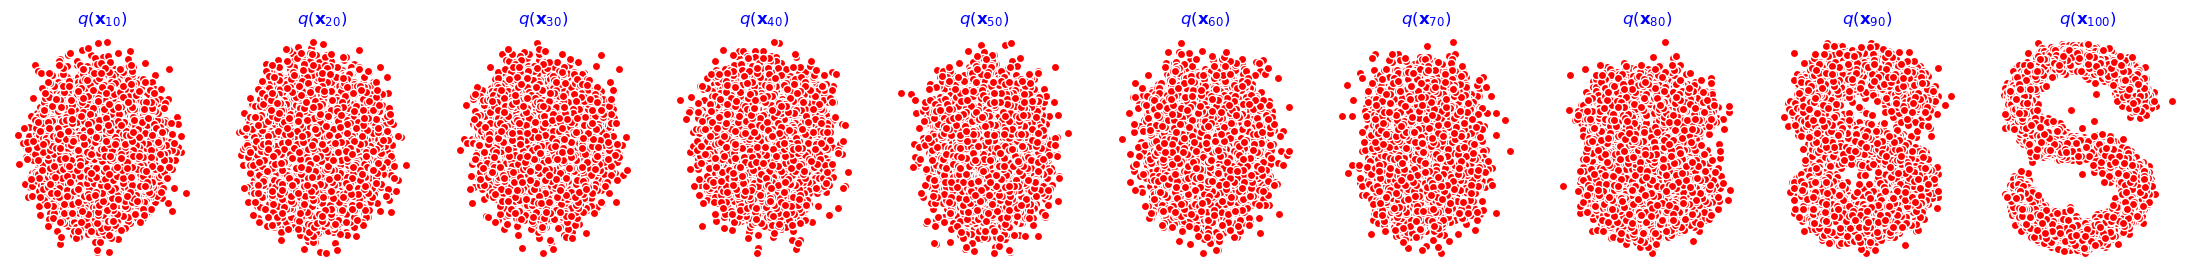

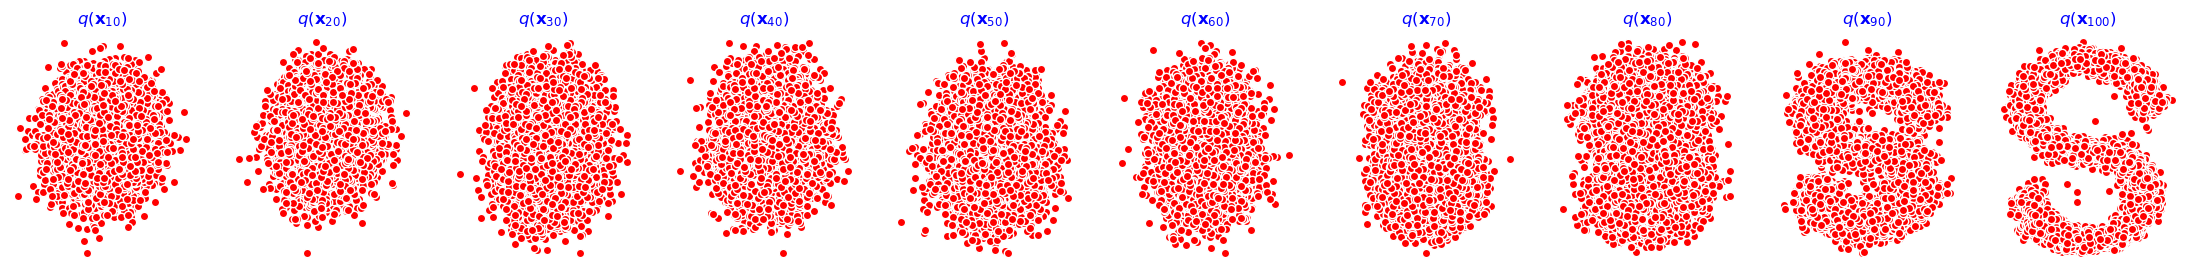

In [64]:
# 模型训练

print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps).to(device)
# model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
  for idx, batch_x in enumerate(dataloader):
    # batch_x = batch_x.to(device)
    loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
    # if t % 100 == 0:
    #   print('batch size: ', batch_x.shape)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),1.) # 梯度裁剪
    optimizer.step()

  if t % 100 == 0:
    print(loss)
    x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

    fig, axs = plt.subplots(1, 10, figsize=(28,3))
    for i in range(1, 11):
      cur_x = x_seq[i * 10].detach()
      axs[i - 1].scatter(cur_x[:, 0].cpu().numpy(), cur_x[:, 1].cpu().numpy(), color='red', edgecolor='white')
      axs[i - 1].set_axis_off()
      axs[i - 1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')